## Introduction

In this notebook we will look at inference attacks against an MNIST classifier.
Specifically, we will use the ART implementation of Fredrikson et al.'s (2015) MI-Face algorithm.

In [27]:

!pip install adversarial-robustness-toolbox

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
from art.attacks.inference.model_inversion.mi_face import MIFace

In [29]:
import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np
from numpy.random import seed
seed(123)

from art.estimators.classification import KerasClassifier
#from art.attacks.inference.model_inversion.mi_face import MIFace
from art.utils import load_dataset

import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
#from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import fashion_mnist,cifar10

import tensorflow as tf
tf.compat.v1.disable_eager_execution()


In [30]:
# Read MNIST dataset
#(x_train, y_train), test_data, min_, max_ = load_dataset(str('fmnist'))
#(x_test, y_test) = test_data


(x_train, y_train), test_data = fashion_mnist.load_data()
(x_test, y_test) = test_data
min_ = np.amin(x_train)
max_ = np.amax(x_train)
print(y_train.shape)

(60000,)


In [33]:
import torch
from torchvision import datasets, transforms

# Define transform to normalize data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Print the shape of the training and testing data
print("Shape of training data:", trainset.train_data.shape)
print("Shape of testing data:", testset.test_data.shape)


Shape of training data: torch.Size([60000, 28, 28])
Shape of testing data: torch.Size([10000, 28, 28])


In [34]:
import matplotlib.image as mpimg

labels_range =10
labels= y_train
labels = labels.tolist()
#print(labels)
label_count =0
for label in range(labels_range):
  indx = -1
  for l in labels:
    indx += 1
    if l == label:
       #print(l)
       label_count += 1
       #plt.figure(figsize=(15,15))
       #plt.subplot(5, 5, 1)
       #plt.imshow( (np.reshape(x_test[indx], (28, 28))), cmap=plt.cm.gray_r)
       #print(l)
       mpimg.imsave("/content/drive/MyDrive/Colab Notebooks/ground_truth_fmnist/"+str(label)+".png", (np.reshape(x_train[indx], (28, 28))),cmap=plt.cm.gray_r)
       break
    if  label_count ==10:
        break

### Train model and initialize attack

In [35]:
# create standard CNN in Keras and wrap with ART KerasClassifier:
from torch import nn
import torch.nn.functional as F
import math
import torch

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D, BatchNormalization, Dropout,Reshape

import numpy as np
from tensorflow.keras.models import Model

from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K



class VAE_CNN:
    def __init__(self, latent_size=784, filter_shape=7, num_classes=10, **kwargs):
        super(VAE_CNN, self).__init__(**kwargs)
        self.latent_size = latent_size
        self.filter_shape = filter_shape
        self.num_classes = num_classes





    def reparameterize(self, mu, logvar):
        z_mean, z_log_var = mu,logvar
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def build(self):

        x= Input(shape=(int(np.sqrt(784)), int(np.sqrt(784)),1))
        conv_encode_1 = Conv2D(32, (3, 3), strides=(1, 1), input_shape=(28, 28,1), name="Encoder_layer_1", activation='relu')(x)
        conv_encode_2 = Conv2D(64, (3, 3), strides=(1, 1), name="Encoder_layer_2", activation='relu') (conv_encode_1)
        flatten_encode_3 =   Flatten(name="Encoder_layer_3")(conv_encode_2)
        linear1_encode_4 = Dense(512, name="Encoder1_layer_4")(flatten_encode_3)
        droup_out = Dropout(0.25,  name="Encoder_layer_5")(linear1_encode_4)
        mu = Dense(self.latent_size, name="Encoder_layer_6_1")(droup_out)
        logvar = Dense(self.latent_size, name="Encoder_layer_6_2")(droup_out)

        z = self.reparameterize(mu, logvar)

        input_classifier = Reshape((int(np.sqrt(self.latent_size)), int(np.sqrt(self.latent_size)),1), name="Reshape_layer")(z)
        conv1 = Conv2D(32, (3, 3), padding='same', input_shape=(int(np.sqrt(self.latent_size)), int(np.sqrt(self.latent_size)),1),activation='relu', name="Classifier_layer_1")(input_classifier)
        maxpool_1 = MaxPool2D((2, 2), name="Classifier_layer_2")(conv1)
        #batchnorm1 = BatchNormalization( name="classifier_layer3")(maxpool_1)
        conv2 = Conv2D(64, (3, 3), padding='same',activation='relu',  name="Classifier_layer_3" )(maxpool_1)
        maxpool_2 = MaxPool2D((2, 2), name="Classifier_layer_4")(conv2)
        #batchnorm2 = BatchNormalization(name="classifier_layer6")(maxpool_2)
        flatten =   Flatten(name="Classifier_layer_5")(maxpool_2)
        fc1 = Dense(256, activation='relu', name="Classifier_layer_6")(flatten)
        droup_out = Dropout(0.25,  name="Classifier_layer_7")(fc1)
        fc2 = Dense(self.num_classes, activation='softmax', name="Classifier_layer_8")(droup_out)

        model =  Model(inputs=x, outputs=fc2)


        #model.add_loss(get_loss(mu, logvar))

        return model

class CNN:
    def __init__(self, latent_size=784, filter_shape=7, num_classes=10, **kwargs):
        super(CNN, self).__init__(**kwargs)
        self.latent_size = latent_size
        self.filter_shape = filter_shape
        self.num_classes = num_classes





    def reparameterize(self, mu, logvar):
        z_mean, z_log_var = mu,logvar
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def build(self):

        x= Input(shape=(int(np.sqrt(self.latent_size)), int(np.sqrt(self.latent_size)),1))
        conv1 = Conv2D(32, (3, 3), padding='same', input_shape=(int(np.sqrt(self.latent_size)), int(np.sqrt(self.latent_size)),1),activation='relu', name="classifier_layer1")(x)
        maxpool_1 = MaxPool2D((2, 2), name="classifier_layer2")(conv1)
        #batchnorm1 = BatchNormalization( name="classifier_layer3")(maxpool_1)
        conv2 = Conv2D(64, (3, 3), padding='same',activation='relu',  name="classifier_layer4" )(maxpool_1)
        maxpool_2 = MaxPool2D((2, 2), name="classifier_layer5")(conv2)
        #batchnorm2 = BatchNormalization(name="classifier_layer6")(maxpool_2)
        flatten =   Flatten(name="encoder1_layer7")(maxpool_2)
        fc1 = Dense(256, activation='relu', name="classifier_layer8")(flatten)
        droup_out = Dropout(0.25,  name="classifier_layer9")(fc1)
        fc2 = Dense(self.num_classes, activation='softmax', name="classifier_layer10")(droup_out)

        model =  Model(inputs=x, outputs=fc2)

        return model

def vae_cnn( min_val, max_val):

    cnn = VAE_CNN()
    model = cnn.build()

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4, epsilon=1e-7, decay=1e-4), loss=categorical_crossentropy, metrics=['accuracy'])
    global_model = KerasClassifier(clip_values=(0, 1),  model=model, use_logits=False)


    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    classifier = KerasClassifier(clip_values=(min_val, max_val),
                                model=model, use_logits=False)
    return classifier

def cnn_mnist( min_val, max_val):

    cnn = CNN()
    model = cnn.build()

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4, epsilon=1e-7, decay=1e-4), loss=categorical_crossentropy, metrics=['accuracy'])
    global_model = KerasClassifier(clip_values=(0, 1),  model=model, use_logits=False)


    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    classifier = KerasClassifier(clip_values=(min_val, max_val),
                                model=model, use_logits=False)
    return classifier

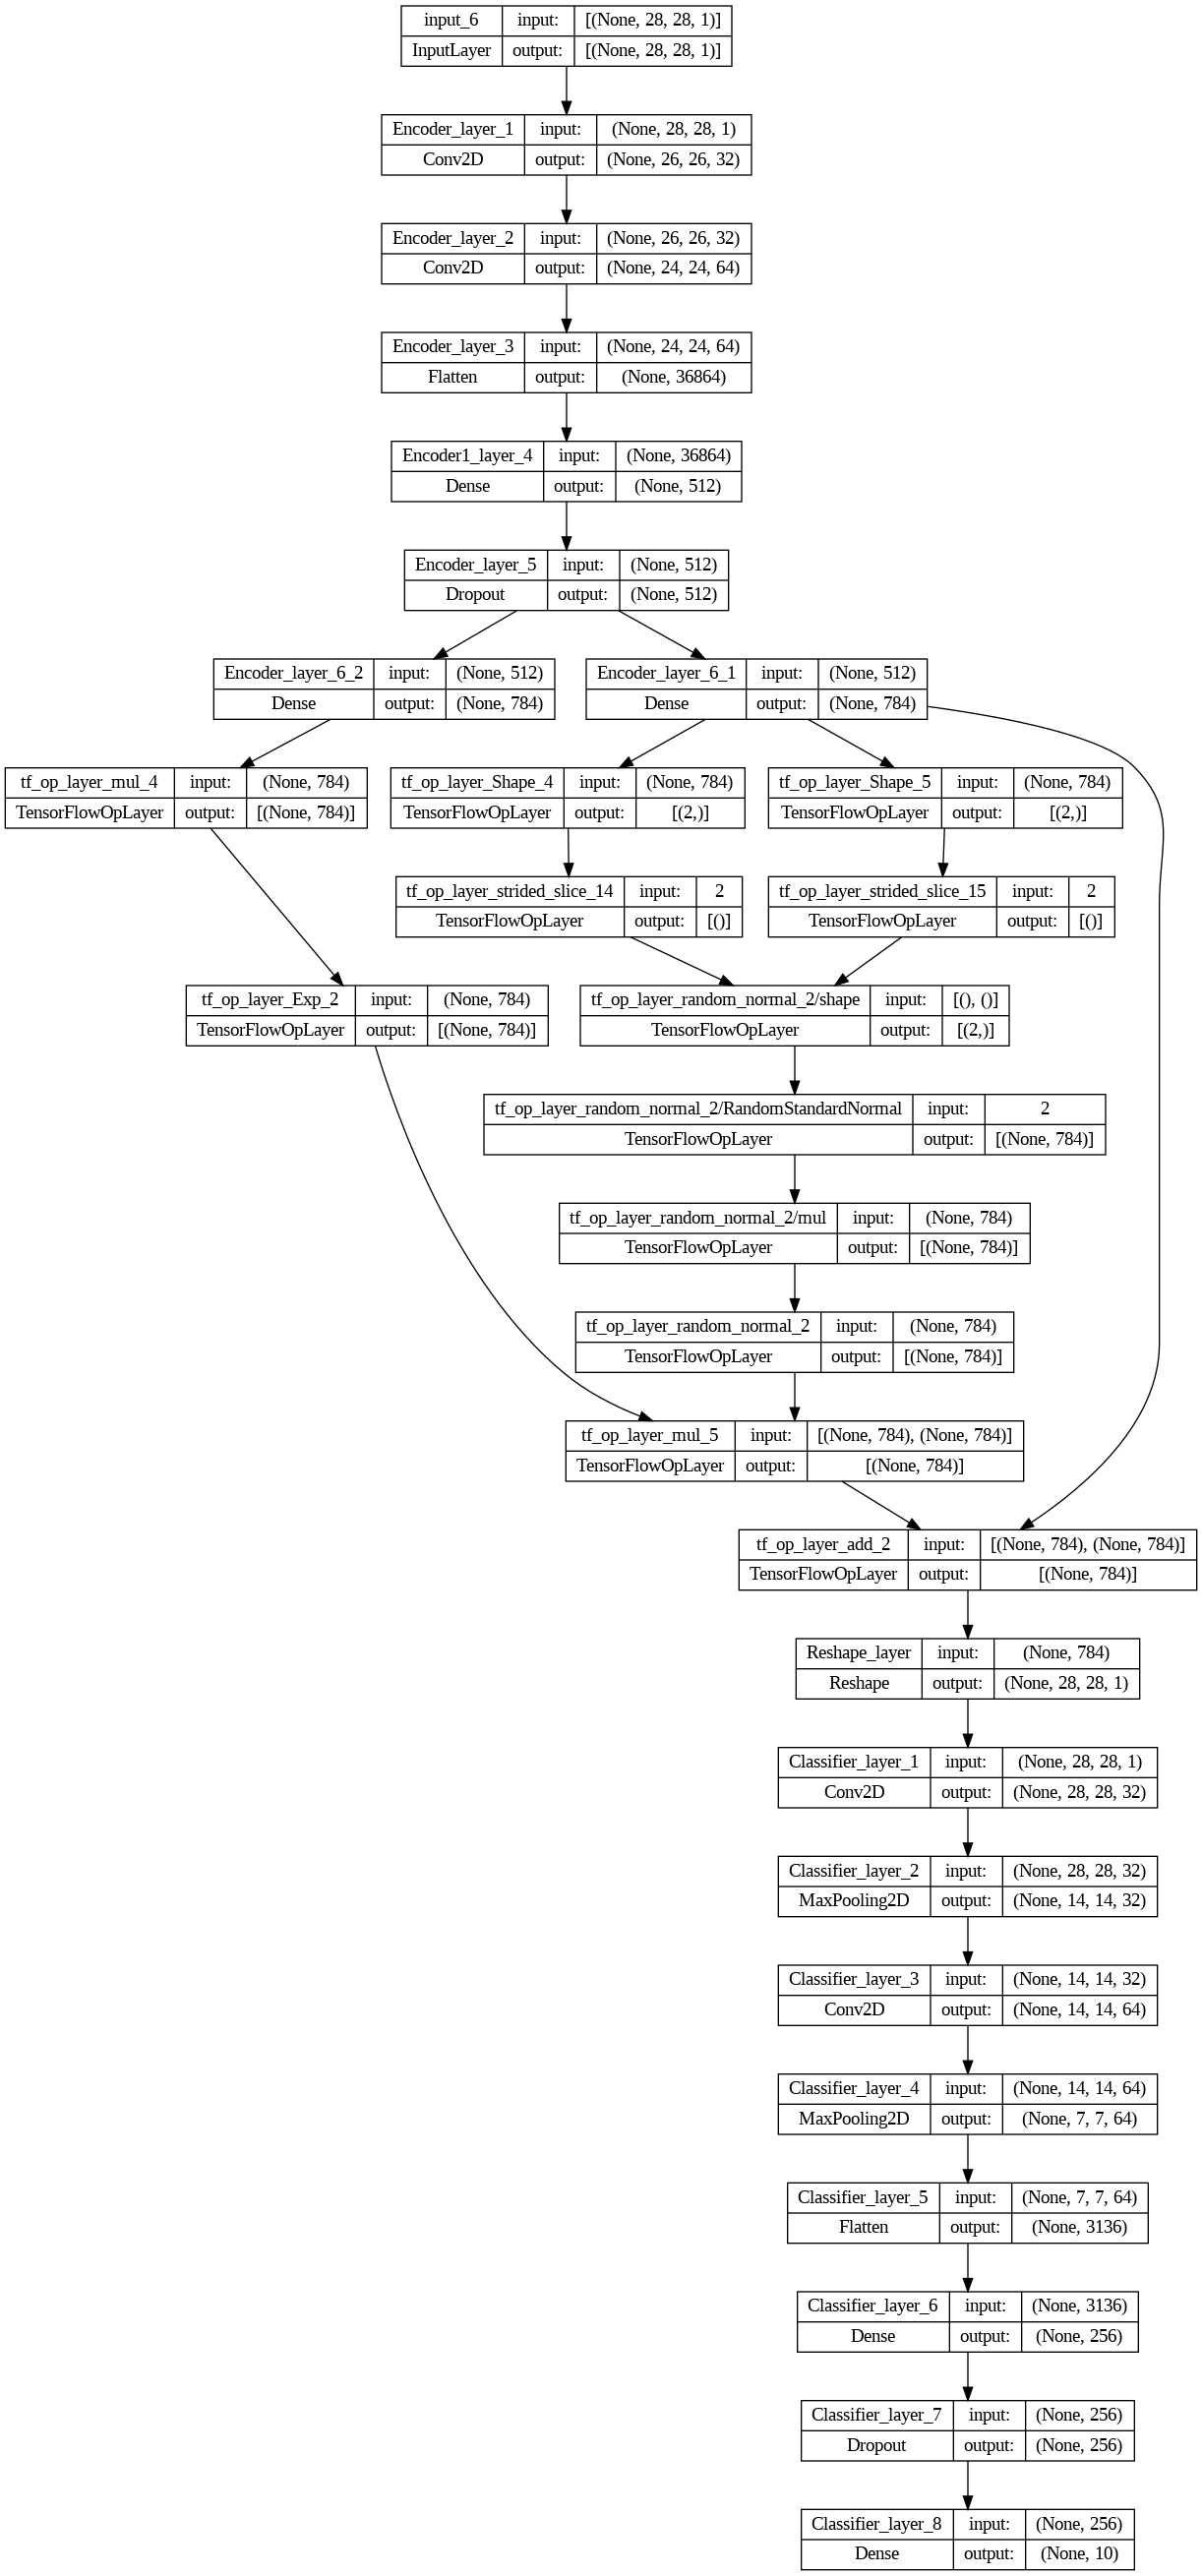

In [36]:
from keras.utils import to_categorical, plot_model
mm = vae_cnn( min_, max_)
plot_model(mm.model, to_file='mlp-mnist.png', show_shapes=True, rankdir='left-to-right')


In [ ]:
import pickle
from keras.utils import to_categorical
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import tensorflow as tf
from keras.utils import to_categorical
import numpy as np
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from keras.losses import categorical_crossentropy
from tensorflow.keras import backend as K
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from numpy.random import RandomState

classifier = cnn_mnist( min_, max_)

num_users = 10
dim=28
ch=1
#for client in range(num_users):
if True:
    classifier.model.load_weights('/content/drive/MyDrive/Colab Notebooks/vae_models_flcdp_fmnist/personalized_model_user_'+str(6)+'_epoch_91.h5') #personalized_model_user_'+str(0)+'_epoch_18.h5
    #my_dict = {}
    #with open('dictionary.pkl', 'rb') as f:
    #    my_dict = pickle.load(f)
    #classifier_layers = ['classifier_layer1', 'classifier_layer11','classifier_layer3', 'classifier_layer4', 'classifier_layer41','classifier_layer6', 'classifier_layer8', 'classifier_layer10']
    #for layer in classifier.model.layers:
    #      if len(layer.get_weights()) > 0 and layer.name in classifier_layers:
     #          layer.set_weights(weights_dict[layer.name])


    # Create the attack.
    # Note: by setting the threshold to 1., the attack will effectively exhaust the maximum number of iterations.
    attack = MIFace(classifier, max_iter=10000, threshold=1.)
    # Our attack target in the following will be to infer information about the training samples
    # for each of the 10 MNIST CLASSES:
    y = np.arange(10)

    # We will experiment with a number of different initializations:

    x_init_white = np.zeros((10, dim, dim, ch))
    x_init_grey = np.zeros((10, dim, dim, ch)) + 0.5
    x_init_black = np.ones((10, dim, dim, ch))
    x_init_random = np.random.uniform(0, 1, (10, dim, dim, ch))
    x_init_average = np.zeros((10, dim, dim, ch)) + np.mean(x_test, axis=0)

    print("Maximum class gradient: %f" % (np.max(np.abs(classifier.class_gradient(x_init_grey, y)))))


    class_gradient = classifier.class_gradient(x_init_grey, y)
    class_gradient = np.reshape(class_gradient, (10, dim*dim*ch ))
    class_gradient_max = np.max(class_gradient, axis=1)

    print("Minimum over all maximum class gradient: %f" % (np.min(x_init_grey)))

    x_infer_from_grey = attack.infer(x_init_grey, y)

    # Plot the inferred images:
    c=[]
    plt.figure(figsize=(15,15))
    for i in range(10):
        plt.subplot(5, 5, i + 1)
        c.append(x_infer_from_grey[0+i,])
        mpimg.imsave("/content/drive/MyDrive/Colab Notebooks/Round_1/user_"+str(client)+"_"+str(i)+"_2.png", (np.reshape(x_infer_from_grey[0+i,]/np.max(x_infer_from_grey[0+i,]), (28, 28))),cmap=plt.cm.gray_r) #, cmap=plt.cm.gray_r

        #plt.imshow( (np.reshape(x_infer_from_grey[0+i,], (28, 28))), cmap=plt.cm.gray_r)

    new_init_average = np.zeros((10, dim, dim, ch)) + np.mean(c, axis=0)


    x_infer_from_grey = attack.infer(new_init_average, y)

    for i in range(10):
        mpimg.imsave("/content/drive/MyDrive/Colab Notebooks/Round_2/user_"+str(client)+"_"+str(i)+"_2.png", (np.reshape(x_infer_from_grey[0+i,], (28, 28))),cmap=plt.cm.gray_r)#cmap=plt.cm.gray_r


Maximum class gradient: 0.152424
Minimum over all maximum class gradient: 0.500000


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]